# Biomas detection from satellite images

This work was based on two papers. The first, by Shuntaro Watanabe, *Automatic vegetation identification in Google Earth images using a convolutional neural network: A case study for Japanese bamboo forests* ([biorxiv:10.1101](https://www.biorxiv.org/content/10.1101/351643v2)) and the second, by Dayong Wang, *Deep Learning for Identifying Metastatic Breast Cancer* ([arxiv:1606.05718](https://arxiv.org/abs/1606.05718)).

In [ ]:
### Install slidingwindow library
!pip install slidingwindow

### Basic libraries
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

### Deep learning libraries
import keras.backend as K
import keras
from keras.models import Sequential
from keras import layers
import tensorflow as tf
from keras.utils import to_categorical
from keras import callbacks

### Metrics
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

### Utilities
import slidingwindow as sw
from keras.preprocessing.image import load_img, img_to_array
from skimage.io import imread, imsave
from sklearn.utils.class_weight import compute_class_weight
from scipy import interp
from itertools import cycle

In [ ]:
## Download and extract dataset
#!wget https://raw.githubusercontent.com/PedroHPCintra/Deep-Learning/master/GreenAreas.zip GreenAreas.zip
#!unzip -P GreenAreas GreenAreas.zip


### Download from google drive
from google.colab import files
if not os.path.isfile('GreenAreas.zip'):
  uploaded = files.upload()
!unzip -P GreenAreas GreenAreas.zip

--2021-04-15 20:39:23--  https://raw.githubusercontent.com/PedroHPCintra/Deep-Learning/master/GreenAreas.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2021-04-15 20:39:23 ERROR 404: Not Found.

--2021-04-15 20:39:23--  http://greenareas.zip/
Resolving greenareas.zip (greenareas.zip)... failed: Name or service not known.
wget: unable to resolve host address ‘greenareas.zip’
unzip:  cannot find or open GreenAreas.zip, GreenAreas.zip.zip or GreenAreas.zip.ZIP.


In [ ]:
!ls GreenAreas/train

ls: cannot access 'GreenAreas/train': No such file or directory


FileNotFoundError: ignored

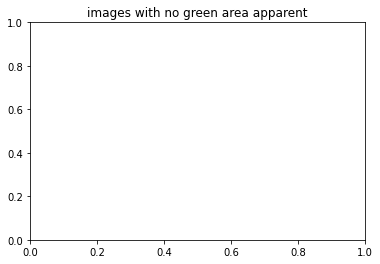

In [ ]:
plt.title("images with no green area apparent")
plt.imshow(imread("GreenAreas/train/City03.jpg"))
plt.show()

plt.title("images with only green area")
plt.imshow(imread("GreenAreas/train/Green02.jpg"))
plt.show()


In [ ]:
def save_to_folder(img_path,directory,size=72,overlap=0.4):
    #read imag from path save windows to the specified directory
    img = imread(img_path)
    basename = os.path.basename(img_path)
    fname = os.path.splitext(basename)[0]
    windows = sw.generate(img, sw.DimOrder.HeightWidthChannel, size, overlap)
    for i,window in enumerate(windows):
        ii = str("{0:05d}".format(i))
        _fname = fname + "_" + ii + ".jpg"
        _img = img[window.indices()]
        if _img.shape !=(size,size,3):
            continue
        img_target_path = os.path.join(directory,_fname)
        
        imsave(img_target_path,_img)
        
files = os.listdir("GreenAreas/train/")
files = [x for x in files if x.endswith(".jpg")]

for file in files:
    save_directory = "GreenAreas/chopped"
    file = os.path.join("GreenAreas/train/",file)
    save_to_folder(file,save_directory)

In [ ]:
files = os.listdir("GreenAreas/chopped/")
files = [x for x in files if x.endswith(".jpg")]

x = []
y = []

for file in files:
    if file.startswith("C"):
        label = 1
    elif file.startswith('W'):
        label = 2
    elif file.startswith('D'):
        label = 3
    elif file.startswith('B'):
        label = 4
    elif file.startswith('F'):
        label = 5
    elif file.startswith('T'):
        label = 6
    else:
        label = 0
    
    img_path = os.path.join("GreenAreas/chopped",file)
    img = load_img(img_path)
    img = img_to_array(img)/255
    x.append(img)
    y.append(label)

x = np.array(x)
y = np.array(y)
print(x.shape,y.shape)

In [ ]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(x,y,test_size=0.2,stratify = y)

print(train_x.shape)
print(train_y.shape)
print(valid_x.shape)
print(valid_y.shape)

In [ ]:
#compute class weight
print(np.unique(train_y,return_counts=True))
print(np.unique(valid_y,return_counts=True))

weight = compute_class_weight('balanced', np.unique(train_y), train_y)
weight = {i : weight[i] for i in range(7)}
print(weight)

In [ ]:
plt.imshow(valid_x[0])
plt.xlabel(f'Classe: {valid_y[0]}')

In [ ]:
train_y = to_categorical(train_y)
valid_y = to_categorical(valid_y)

In [ ]:
model = Sequential([
    layers.Conv2D(16,(3,3),name="conv1",input_shape=(72,72,3),activation="relu",padding="same"),   
    layers.MaxPool2D((2,2),name="pool1"),
    layers.Dropout(0.2),
    layers.Conv2D(32,(3,3),name="conv2",padding="same"),
    layers.Activation("relu"),
    layers.MaxPool2D((2,2),name="pool2"),
    layers.Dropout(0.2),
    layers.Conv2D(32,(3,3),name="conv3",padding="same"),
    layers.Activation("relu"),
    layers.MaxPool2D((2,2),name="pool3"),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(7),
    layers.Activation("softmax",name="prediction")
]
)

earlystopping = callbacks.EarlyStopping(monitor ="val_accuracy",  
                                        mode ="max", patience = 7,  
                                        restore_best_weights = True)

model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["acc"])

model.summary()

In [ ]:
history = model.fit(train_x,train_y,epochs=20,validation_data=(valid_x,valid_y),class_weight=weight,
                    callbacks = [earlystopping])

### Evaluation of the model

In [ ]:
plt.plot(history.history['loss'], color = 'red', label = 'Loss')
plt.plot(history.history['val_loss'], color = 'blue', label = 'Validation loss')
plt.xlabel('Nº epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
plt.plot(history.history['acc'], color = 'red', label = 'Accuracy')
plt.plot(history.history['val_acc'], color = 'blue', label = 'Validation accuracy')
plt.xlabel('Nº epochs')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
pred = model.predict(valid_x)

In [ ]:
### CURVA ROC

pred = model.predict(valid_x)

n_classes = valid_y.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(valid_y[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(valid_y.ravel(), pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize = (10,8))#, dpi = 300)
lw = 1.3
plt.plot(fpr["micro"], tpr["micro"],
          label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
          color='deeppink', linestyle=':', linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
          label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
          color='navy', linestyle=':', linewidth=2)

colors = cycle(['indigo', 'darkred', 'cornflowerblue', 'black', 'darkgreen', 'magenta', 'goldenrod', 'darkcyan'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 12)
plt.ylabel('True Positive Rate', fontsize = 12)
plt.title('Curva ROC para as classes do modelo', fontsize = 14)
lgd = plt.legend(bbox_to_anchor=(1.3, 1), loc='upper center', borderaxespad=0., fontsize = 12)

In [ ]:
pred = np.argmax(pred, axis=-1)

# Original labels
valid_y = np.argmax(valid_y, axis=-1)

cm  = confusion_matrix(valid_y, pred)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(7), ['Green', 'City', 'Water', 'Desert', 'Beach', 'Farm', 'Tundra'], fontsize=16)
plt.yticks(range(7), ['Green', 'City', 'Water', 'Desert', 'Beach', 'Farm', 'Tundra'], fontsize=16)
plt.show()

In [ ]:
report = classification_report(valid_y, pred, labels = [0, 1, 2, 3, 4],
                      target_names = ['Green', 'City', 'Water', 'Desert', 'Beach'], output_dict=True)

report = pd.DataFrame(report)

In [ ]:
report

## Let's classify some satellite images

In [ ]:
#read test data
img_path = "GreenAreas/test/test14.jpg"
img = load_img(img_path)
img = img_to_array(img)/255
plt.imshow(img)
plt.show()

#create subimages
patches = []
windows = sw.generate(img, sw.DimOrder.HeightWidthChannel, 64, 0.6)
for i,window in enumerate(windows):
    _img = img[window.indices()]
    patches.append(_img)
patches = np.array(patches)

#check total images, how many images are tiled at height direction, and width direction
n_total = len(windows)
_x = 0
for i,window in enumerate(windows):
    if _x != window.x:
        n_x = i
        print(n_x)
        break
    _x = window.x


print(n_total,n_x,n_total//n_x)

(2379,)
[0.9970385  0.99986136 0.9898503  ... 0.00448088 0.02269877 0.01433444]


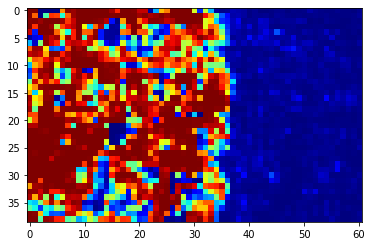

In [ ]:
#predict the city probability for all the cropped images, and reshape back to its original form.
qual = 1

predictions = model.predict(patches)[:,qual]
print(predictions.shape)
print(predictions)

city = np.reshape(predictions,(n_total//n_x,n_x))
city = np.rot90(city)
city = np.flip(city,axis=0)
plt.imshow(city,cmap="jet")

In [ ]:
h_factor = img.shape[0]//city.shape[0]
w_factor = img.shape[1]//city.shape[1]
print(h_factor)

from scipy.ndimage import zoom
zoomed = zoom(city,(h_factor,w_factor))

print(zoomed.shape)

13
(507, 793)


In [ ]:
def classe(x):
  if x == 0:
    return 'Green Areas', 'Greens'
  elif x == 1:
    return 'City', 'Reds'
  elif x == 2:
    return 'Water', 'Blues'
  elif x == 3:
    return 'Desert', 'YlOrBr'
  elif x == 4:
    return 'Beach', 'YlOrBr'
  elif x == 5:
    return 'Farm', 'Purples'
  elif x == 6:
    return 'Tundra/Ice', 'gray'

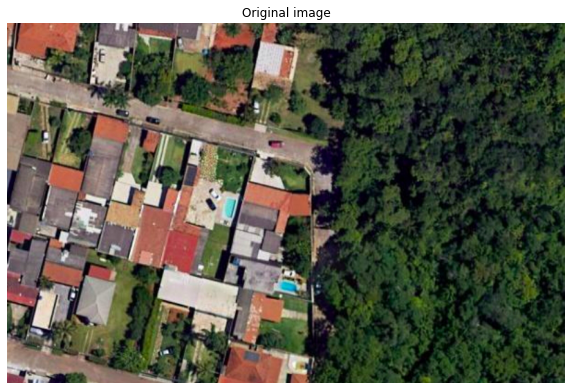

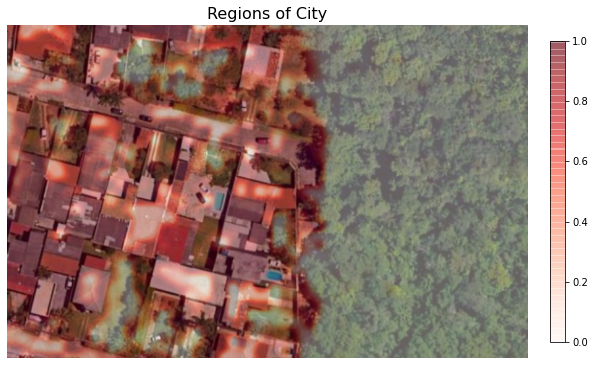

In [ ]:
#result
plt.figure(figsize=(10,8))
plt.imshow(img)
plt.axis('off')
plt.title('Original image')

plt.figure(figsize=(10,8))
plt.imshow(img)
plt.imshow(zoomed,alpha=0.4,vmax=1.0,vmin=0,cmap=classe(qual)[1])
plt.axis('off')
plt.title(f'Regions of {classe(qual)[0]}', fontsize = 16)

plt.colorbar(fraction=0.027, pad=0.04,alpha=0)
plt.show()